In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import csv

2024-02-10 08:12:03.249353: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-10 08:12:03.249456: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-10 08:12:03.366759: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-10 08:12:03.576235: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-10 08:12:05.256128: W tensorflow/compiler/tf2

In [4]:
import os

os.getcwd()
os.chdir(r"./accelerometer_data/")
os.listdir()

['circle', 'square', 'e_circle', 'e_square', 'triangle', 'e_triangle']

In [3]:
os.chdir("..")
# os.chdir("acc_py")
# os.getcwd()

In [3]:
# Generate synthetic accelerometer data for three shapes: Circle, Square, Triangle
np.random.seed(42)

# Number of samples for each shape
# num_samples = 101

# Accelerometer data (x, y, z)
# shapes = {}
maxlen = 0
rec_len = 0
for shape in os.listdir():
    if shape[0] != 'e':
        continue
    # shapes[shape] = 0
    os.chdir(f"./{shape}")
    print(f"In the {shape} directory")
    for file in os.listdir():
        rec_len = 0
        with open(file, "r") as f:
            reader = csv.reader(f)
            data = list(reader)[1:]
            d_array = np.array(data, dtype = float)
            # rec_len = d_array.shape[0]
            maxlen = max(maxlen, d_array.shape[0])
            # shapes[shape] = np.stack((shapes[shape], d_array))
            # shapes[shape].append(d_array)
        
        # if rec_len <= 5 or rec_len > 85:
        #     os.remove(file)
        #     shapes[shape] += 1
    # shapes[shape] = np.array(shapes[shape])

    os.chdir("..")


# print(shapes)

print(maxlen)
# print(shapes)


In the e_circle directory
In the e_square directory
In the e_triangle directory
83


In [5]:
hist_data = []
shapes = {}

for shape in os.listdir():
    if shape[0] != 'e':
        continue
    os.chdir(f"./{shape}")
    print(f"In the {shape} directory")
    shape = shape[2:]
    for i, file in enumerate(os.listdir()):
        with open(file, "r") as f:
            try:
                reader = csv.reader(f)
                data = list(reader)[1:]
                data.extend([['0.0' for _ in range(4)] for _ in range(83 - len(data))])
                d_array = np.array(data, dtype = float)
                d_array = d_array[:, 1:]
                d_array.reshape((1, 83, 3))
                # hist_data.append(d_array.shape[0])
                if i == 0:
                    shapes[shape] = d_array
                else:
                    shapes[shape] = np.append(shapes[shape], d_array)
            except Exception as e:
                os.chdir("..")
                raise e
            
    shapes[shape] = shapes[shape].reshape((101, 83, 3))
    print(shape, shapes[shape].shape)
    os.chdir("..")

# shapes['e_circle'] = shapes['e_circle'].reshape((101, 83, 3))
# print(shapes['e_circle'])

In the e_circle directory
circle (101, 83, 3)
In the e_square directory
square (101, 83, 3)
In the e_triangle directory
triangle (101, 83, 3)


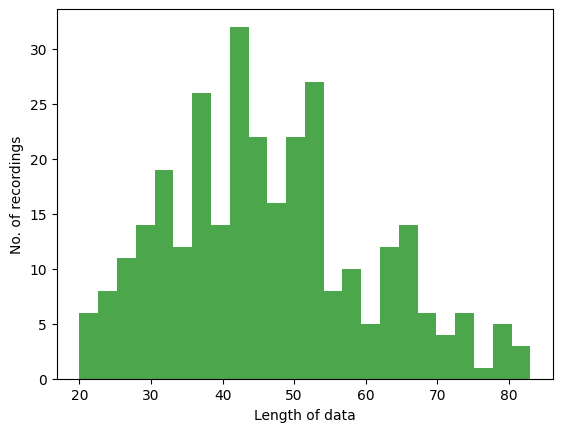

In [4]:
import matplotlib.pyplot as plt

plt.hist(hist_data, int(120/5), color = 'green', alpha = 0.7)
plt.xlabel('Length of data')
plt.ylabel('No. of recordings')
plt.show()

In [6]:

samples = 101

# Combine data and labels
data = np.vstack((shapes['circle'], shapes['square'], shapes['triangle']))
labels = np.hstack((['circle'] * samples, ['square'] * samples, ['triangle'] * samples))
labels.shape


(303,)

In [7]:
# Encode labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, encoded_labels, test_size=0.2, random_state=42)

In [122]:
from tensorflow import keras

model = keras.models.Sequential()

model.add(keras.Input(shape = (X_train.shape[1], X_train.shape[2])))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.Dense(8, activation='relu'))
# model.add(keras.layers.Dropout(0.1))
model.add(keras.layers.Dense(3, activation='softmax'))
# model.add(SimpleRNN(64, input_shape=(X_train.shape[1], X_train.shape[2])))
# model.add(Dense(3, activation='softmax'))

# Compile the model
loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy'])

In [123]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 249)               0         
                                                                 
 dense_10 (Dense)            (None, 32)                8000      
                                                                 
 dense_11 (Dense)            (None, 16)                528       
                                                                 
 dense_12 (Dense)            (None, 8)                 136       
                                                                 
 dense_13 (Dense)            (None, 3)                 27        
                                                                 
Total params: 8691 (33.95 KB)
Trainable params: 8691 (33.95 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [124]:
model.fit(X_train, y_train, epochs=40, batch_size=1, validation_split=0.2)

Epoch 1/40
193/193 [==============================] - 2s 3ms/step - loss: 0.9656 - accuracy: 0.5233 - val_loss: 0.8063 - val_accuracy: 0.6735
Epoch 2/40
193/193 [==============================] - 1s 3ms/step - loss: 0.6218 - accuracy: 0.7772 - val_loss: 0.7598 - val_accuracy: 0.7347
Epoch 3/40
193/193 [==============================] - 1s 3ms/step - loss: 0.5062 - accuracy: 0.8031 - val_loss: 0.7249 - val_accuracy: 0.6735
Epoch 4/40
193/193 [==============================] - 1s 3ms/step - loss: 0.4137 - accuracy: 0.8342 - val_loss: 0.7735 - val_accuracy: 0.6735
Epoch 5/40
193/193 [==============================] - 1s 3ms/step - loss: 0.3541 - accuracy: 0.8653 - val_loss: 0.8347 - val_accuracy: 0.7143
Epoch 6/40
193/193 [==============================] - 1s 3ms/step - loss: 0.3250 - accuracy: 0.8653 - val_loss: 0.7556 - val_accuracy: 0.6939
Epoch 7/40
193/193 [==============================] - 1s 3ms/step - loss: 0.3002 - accuracy: 0.8912 - val_loss: 0.7652 - val_accuracy: 0.7143
Epoch 

In [125]:
y_pred = np.argmax(model.predict(X_test), axis=1)

# Decode predictions
# decoded_predictions = label_encoder.inverse_transform(y_pred)

# print(decoded_predictions)
# print(y_pred)

# Calculate accuracy
print(classification_report(y_pred, y_test, target_names=['circle', 'square', 'triangle']))
print(confusion_matrix(y_pred, y_test))

2/2 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

      circle       0.85      0.85      0.85        20
      square       0.79      0.83      0.81        18
    triangle       0.82      0.78      0.80        23

    accuracy                           0.82        61
   macro avg       0.82      0.82      0.82        61
weighted avg       0.82      0.82      0.82        61

[[17  1  2]
 [ 1 15  2]
 [ 2  3 18]]


In [126]:
os.chdir("..")
model.save("acc")

INFO:tensorflow:Assets written to: acc/assets


INFO:tensorflow:Assets written to: acc/assets


In [127]:
import random
import datetime

random.seed(datetime.datetime.now().microsecond + datetime.datetime.now().second)

model = keras.models.load_model("acc")

def repr_dataset():
    data = shapes[random.choice(['circle', 'square', 'triangle'])][random.randint(0, 100)]
    yield [np.float32(data)]

tflite_name = "acc_edge_small_int8.tflite"

tflite_converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_converter.representative_dataset = repr_dataset
tflite_converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
tflite_converter.inference_input_type = tf.uint8
tflite_converter.inference_output_type = tf.uint8
tflite_converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = tflite_converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmp77ggm_mk/assets


INFO:tensorflow:Assets written to: /tmp/tmp77ggm_mk/assets
/home/risb/Desktop/acc_py/rnn/lib/python3.11/site-packages/tensorflow/lite/python/convert.py:953: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
2024-02-10 09:23:15.819858: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-02-10 09:23:15.819885: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-02-10 09:23:15.820049: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp77ggm_mk
2024-02-10 09:23:15.820691: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-02-10 09:23:15.820702: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp77ggm_mk
2024-02-10 09:23:15.822667: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-02-10 0

In [128]:

open(tflite_name, 'wb').write(tflite_model)

12608

In [129]:
def hex_to_carray(hex_data, var: str) -> str:
    c_str = ''

    # Add header
    c_str += '#pragma once\n\n'
    c_str += 'const unsigned int ' + var + '_len = ' + str(len(hex_data)) + ';\n'
    c_str += 'const unsigned char ' + var + '[] = {\n\t'

    for i, val in enumerate(hex_data):
        c_str += f"0x{val:02x}{',' if i+1 < len(hex_data) else ''}"
        if (i+1) % 100 == 0:
            c_str += '\n\t'
    
    c_str += '\n};\n'

    return c_str

In [130]:
with open('shape_model_int8.hpp', 'w') as f:
    f.write(hex_to_carray(tflite_model, 'shape_model'))

In [118]:
import random
import datetime


random.seed(datetime.datetime.now().microsecond + datetime.datetime.now().second)

interpreter = tf.lite.Interpreter(model_path='acc_edge_small_int8.tflite')

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

interpreter.allocate_tensors()

# input details
print(input_details)
# output details
print(output_details)

# interpreter.set_tensor(input_details[0]['index'], np.float32(shapes['square'][random.randint(0, 100)].reshape((1, 83, 3))))
# interpreter.invoke()

# output_data = interpreter.get_tensor(output_details[0]['index'])

# print(output_data)

[{'name': 'serving_default_input_2:0', 'index': 0, 'shape': array([ 1, 83,  3], dtype=int32), 'shape_signature': array([-1, 83,  3], dtype=int32), 'dtype': <class 'numpy.uint8'>, 'quantization': (0.015313724987208843, 124), 'quantization_parameters': {'scales': array([0.01531372], dtype=float32), 'zero_points': array([124], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
[{'name': 'StatefulPartitionedCall:0', 'index': 14, 'shape': array([1, 3], dtype=int32), 'shape_signature': array([-1,  3], dtype=int32), 'dtype': <class 'numpy.uint8'>, 'quantization': (0.00390625, 0), 'quantization_parameters': {'scales': array([0.00390625], dtype=float32), 'zero_points': array([0], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
